In [1]:
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.stats import gaussian_kde

sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.verification import load_tganom_and_compute, load_tgex_and_compute, build_fit_nn_model, compute_bss, compute_kss, compute_auc, reduce_to_ranks

sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.utils import reliability_plot

2022-01-04 15:50:24.423081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-04 15:50:24.423101: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Investigation of most successful prediction
(When going through the standard objective predictor selection).

In [2]:
name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15'
total, test_only = build_fit_nn_model(predictandname = name, npreds = 4)
trainval_only = total.drop(test_only.index, axis = 0)

fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200


2022-01-04 15:51:02.966038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-04 15:51:02.966061: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-04 15:51:02.966078: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc160104): /proc/driver/nvidia/version does not exist
2022-01-04 15:51:02.966257: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-04 15:51:03.017687: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optim

41/41 [==============================] - 0s 4ms/step - loss: 0.7268 - accuracy: 0.5498 - brier: 0.2601 - val_loss: 0.7866 - val_accuracy: 0.4826 - val_brier: 0.2893
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7244 - accuracy: 0.5498 - brier: 0.2590 - val_loss: 0.7844 - val_accuracy: 0.4826 - val_brier: 0.2885
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7205 - accuracy: 0.5498 - brier: 0.2570 - val_loss: 0.7810 - val_accuracy: 0.4826 - val_brier: 0.2872
Epoch 4/200
41/41 [==============================] - 0s 987us/step - loss: 0.7134 - accuracy: 0.5645 - brier: 0.2538 - val_loss: 0.7757 - val_accuracy: 0.4826 - val_brier: 0.2850
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7022 - accuracy: 0.5949 - brier: 0.2485 - val_loss: 0.7685 - val_accuracy: 0.4905 - val_brier: 0.2819
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6882 - accuracy: 0.6019 - brier: 0.2421 - val_loss

Epoch 47/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5329 - accuracy: 0.7659 - brier: 0.1701 - val_loss: 0.6173 - val_accuracy: 0.6388 - val_brier: 0.2166
Epoch 48/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5317 - accuracy: 0.7582 - brier: 0.1700 - val_loss: 0.6234 - val_accuracy: 0.6420 - val_brier: 0.2183
Epoch 49/200
41/41 [==============================] - 0s 982us/step - loss: 0.5311 - accuracy: 0.7628 - brier: 0.1697 - val_loss: 0.6211 - val_accuracy: 0.6372 - val_brier: 0.2176
Epoch 50/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5311 - accuracy: 0.7621 - brier: 0.1695 - val_loss: 0.6233 - val_accuracy: 0.6420 - val_brier: 0.2182
Epoch 51/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5299 - accuracy: 0.7652 - brier: 0.1692 - val_loss: 0.6165 - val_accuracy: 0.6404 - val_brier: 0.2164
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
excluding test years [20

In [13]:
test_only.columns[test_only.columns.str.endswith('_bs')]

Index(['pi_bs', 'ppsf_bs', 'climatology_bs', 'trend_bs'], dtype='object')

In [32]:
n_iter = 2000
bs = pd.DataFrame(np.nan, columns = pd.MultiIndex.from_product([['trainval','test'],test_only.columns[test_only.columns.str.endswith('_bs')]], names = ['set','forecast']), index = pd.RangeIndex(n_iter))
for i in range(n_iter):

    trainval_sample = np.random.randint(low = 0, high = trainval_only.shape[0], size = trainval_only.shape[0]) # bootstrap sample with replacement.
    test_sample = np.random.randint(low = 0, high = test_only.shape[0], size = test_only.shape[0])
    
    for forecast_key in bs.columns.get_level_values('forecast').unique():
        bs.loc[i,('test',forecast_key)] = test_only[forecast_key].iloc[test_sample.tolist()].mean()
        bs.loc[i,('trainval',forecast_key)] = trainval_only[forecast_key].iloc[trainval_sample.tolist()].mean()

In [35]:
bs.columns

MultiIndex([('trainval',          'pi_bs'),
            ('trainval',        'ppsf_bs'),
            ('trainval', 'climatology_bs'),
            ('trainval',       'trend_bs'),
            (    'test',          'pi_bs'),
            (    'test',        'ppsf_bs'),
            (    'test', 'climatology_bs'),
            (    'test',       'trend_bs')],
           names=['set', 'forecast'])

In [42]:
# scale test and trainval BS separately based on the mean raw score
bszero = bs.copy()
bszero['test'] = bs['test'] - float(bs[('test', 'pi_bs')].mean())
bszero['trainval'] = bs['trainval'] - float(bs[('trainval', 'pi_bs')].mean())

In [43]:
def to_kernel_density(vals):
    if isinstance(vals, (pd.Series, pd.DataFrame)):
        vals = vals.values.squeeze()
    positions = np.linspace(start = vals.min(), stop = vals.max(), num = 100)
    density = gaussian_kde(vals)(positions)
    return(positions, density)

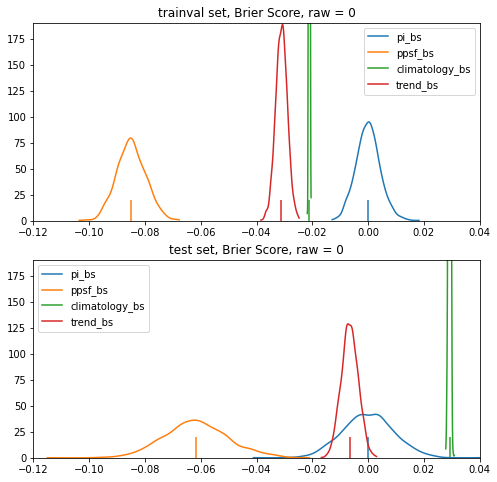

In [46]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (8,8), squeeze = False)
for key in bszero.columns:
    i = bszero.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    im = ax.plot(*to_kernel_density(bszero[key]),label = key[-1])
    ax.vlines(x = float(bszero[key].mean()), ymin=0, ymax = 20, color = im[0].get_c())
    ax.set_xlim(left = -0.12, right = 0.04)
    ax.set_ylim(0,190)
    ax.set_title(f'{key[0]} set, Brier Score, raw = 0')
    ax.legend()

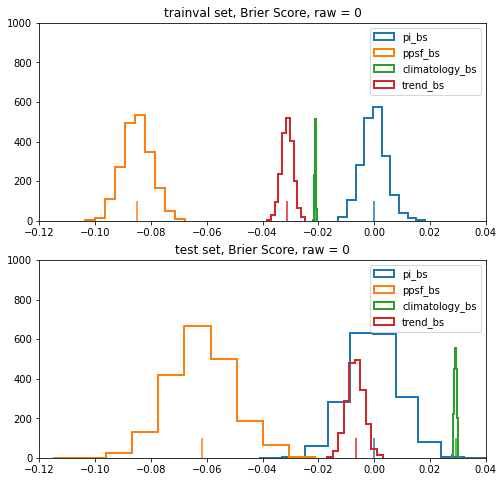

In [58]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (8,8), squeeze = False)
for key in bszero.columns:
    i = bszero.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    im = ax.hist(bszero[key], label = key[-1], histtype = 'step', lw = 2)
    ax.vlines(x = float(bszero[key].mean()), ymin=0, ymax = 100, color = im[2][0].get_edgecolor())
    #ax.set_xlim(left = -0.12, right = 0.08)
    ax.set_xlim(left = -0.12, right = 0.04)
    ax.set_ylim(0,1000)
    ax.set_title(f'{key[0]} set, Brier Score, raw = 0')
    ax.legend()

In [64]:
test_only.columns.name = 'type'
trainval_only.columns.name = 'type'

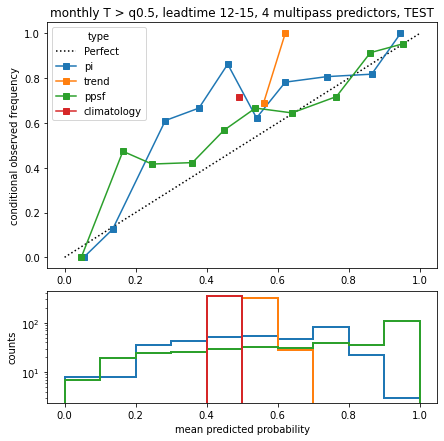

In [63]:
fig, (axrel, axhist) = reliability_plot(y_true = test_only['observation'], y_probs=test_only[['pi', 'trend','ppsf', 'climatology']])
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TEST')
plt.show()

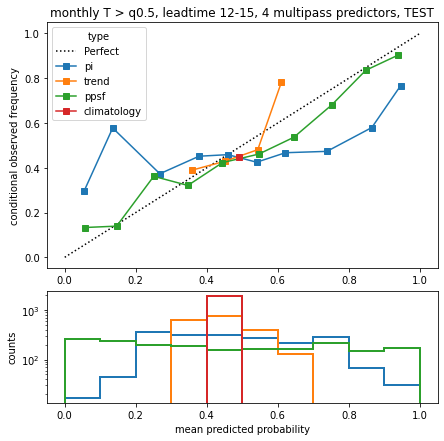

In [65]:
fig, (axrel, axhist) = reliability_plot(y_true = trainval_only['observation'], y_probs=trainval_only[['pi', 'trend','ppsf', 'climatology']])
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TEST')
plt.show()

## Broad verification
Multiple metrics, thresholds, time scales, lead times. 